In [2]:
import requests
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
from itertools import cycle
from csv import reader
import seaborn as sns
import numpy as np
import statistics
import ast
import sys
import time
import os
import csv

In [ ]:
sectors = ['basicmaterials', 'communicationservices', 
           'consumercyclical', 'consumerdefensive', 'energy',
          'financial', 'healthcare', 'industrials', 'realestate',
          'technology', 'utilities']


rawURL = 'https://finviz.com/screener.ashx?v=152&c=0,1,2,3,4,5,6,8,9,10,11,13,17,18,20,22,23,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,51&f=sec_'
path = 'C:\\Users\\faiza\\OneDrive\\Desktop\\StockData\\Sector Data\\'


for i in range(len(sectors)):
    URL = rawURL + sectors[i]
    print(URL)

In [4]:
def getProxies(inURL):
    page = requests.get(inURL)
    soup = BeautifulSoup(page.text, 'html.parser')
    terms = soup.find_all('tr')
    IPs = []

    for x in range(len(terms)):  
        
        term = str(terms[x])        
        
        if '<tr><td>' in str(terms[x]):
            pos1 = term.find('d>') + 2
            pos2 = term.find('</td>')

            pos3 = term.find('</td><td>') + 9
            pos4 = term.find('</td><td>US<')
            
            IP = term[pos1:pos2]
            port = term[pos3:pos4]
            
            if '.' in IP and len(port) < 6:
                IPs.append(IP + ":" + port)
                #print(IP + ":" + port)

    return IPs 


def clean(stng):
    
    output = ''

    for letter in stng:
        if letter not in "[]()'": #and letter != ' ':
            output += letter
        
    return output


agent = {"User-Agent":'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'}
proxyURL = "https://www.us-proxy.org/"
pxs = getProxies(proxyURL)
proxyPool = cycle(pxs)

In [ ]:
header = 'Index, Symbol, Company Name, Sector, Industry, Country, Market Cap, Forward PE, PEG, Price/Sales, Price/Book, Price/FCF, EPS This Y, EPS Next Y, EPS Next 5Y, EPS Q/Q, Sales Q/Q, ROA, ROE, ROI, Current Ratio, Quick Ratio, LT Debt/Equity, Debt/Equity, Gross Margin, Operating Margin, Net Margin, Perf Month, Perf Quarter, Perf Half Y, Perf Year, Perf YTD, Volatility (Month)' + '\n'
allData = []

for i in range(len(sectors)):
    
    pageCounter = 1
    stocksAdded = 20
    stockData = []

    while stocksAdded == 20:

        stocksAdded = 0

        URL = rawURL + sectors[i] + '&r=' + str(pageCounter)

        print(URL, pageCounter)

        page = requests.get(URL, headers=agent, proxies = {"http": next(proxyPool)})
        soup = BeautifulSoup(page.content, 'html.parser')

        tableLightStocks = soup.find_all('tr', {'class': 'table-light-row-cp'})
        tableDarkStocks = soup.find_all('tr', {'class': 'table-dark-row-cp'})

        tableStocks = list(tableLightStocks) + list(tableDarkStocks)

        for result in tableStocks:

            result = str(result)
            rawString = result
            data = ''

            while '<' in rawString:

                rawString = rawString[rawString.find('<') + 3 : ]
                stng = rawString[rawString.find('>') + 1 : rawString.find('<')]

                if len(stng) > 0:
                    data += stng.replace('&amp;', '&').replace(',', '') + ', '

            data = '[' + data[3 : -2] + ']'

            stockData.append([tuple(map(str, data.split(', '))) ])
            allData.append([tuple(map(str, data.split(', '))) ])
            stocksAdded += 1

        pageCounter += 20
        print(stocksAdded)


    MyFile = open(path + 'SectorData - ' + sectors[i] + '.csv', 'w')
    MyFile.write(header)

    for row in stockData:
        MyFile.write(clean(str(row)))
        MyFile.write('\n')

    MyFile.close()
    print('Saved:', sectors[i])

                      
print(stockData)
        

In [5]:
MyFile = open(path + 'SectorData.csv', 'w')
MyFile.write(header)

for row in allData:
    MyFile.write(clean(str(row)))
    MyFile.write('\n')

MyFile.close()

technology raw net margin Avg: -2.1032755298651273 4.277257111170864

Metrics Available: ['Forward PE', 'PEG', 'Price/Sales', 'Price/Book', 'Price/FCF', 'EPS This Y', 'EPS Next Y', 'EPS Next 5Y', 'EPS Q/Q', 'Sales Q/Q', 'ROA', 'ROE', 'ROI', 'Current Ratio', 'Quick Ratio', 'LT Debt/Equity', 'Debt/Equity', 'Gross Margin', 'Operating Margin', 'Net Margin', 'Perf Month', 'Perf Quarter', 'Perf Half Y', 'Perf Year', 'Perf YTD', 'Volatility (Month)']

Avg 2.0 Start 16.030 Change 4.2772


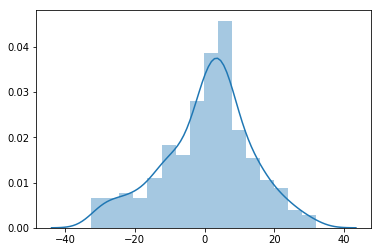

In [8]:
def getAverage(sector, metric, lessThan):
    
    with open(path + 'SectorData - ' + sector + '.csv', 'r') as rdr:
        
        csv = reader(rdr)
        sectorData = list(csv)
        
    avg = 0
    columnToSearch = 0 
    validCells = 0
    metrics = []
    
    for column in range(len(sectorData[0])):
        
        if sectorData[0][column][1: ].casefold() == metric.casefold():
            columnToSearch = column

            
    for row in range(1, len(sectorData)):
        
        cell = sectorData[row][columnToSearch].replace('%', '').replace(' ', '')
        
        if cell != '-':
            
            avg += float(cell)
            metrics.append(float(cell))
            validCells += 1
    
    elements = np.array(metrics)
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)

    for i in range(2):
        smoothedList = [x for x in metrics if (x > mean - 2 * sd)]
        smoothedList = [x for x in smoothedList if (x < mean + 2 * sd)]

        mean = np.mean(smoothedList, axis=0)
        sd = np.std(smoothedList, axis=0)

    metricAvg = avg / validCells 
    metricStd = np.std(smoothedList, axis = 0) / 3
    
    
    percentile = np.percentile(smoothedList, 90)
    smoothedAvg =  np.percentile(smoothedList, 50)
    
    if lessThan == True:
        percentile = np.percentile(smoothedList, 10)
    
    sns.distplot(smoothedList);
    
    print(sector + ' raw ' + metric + ' Avg:', metricAvg, metricStd)
    print('\nMetrics Available:', [metric[1 : ] for metric in sectorData[0][7 : ]])
    
    return smoothedAvg, percentile, metricStd
    

sectorData = []

smoothAvg, start, change = getAverage('technology', 'net margin', False)
print('\nAvg', smoothAvg, 'Start', str(start)[0:6], 'Change', str(change)[0:6])

In [67]:
header = [sector for sector in sectors]
header = ' ,' + (" ".join(header)).replace(' ', ', ') + '\n'
header

' ,basicmaterials, communicationservices, consumercyclical, consumerdefensive, energy, financial, healthcare, industrials, realestate, technology, utilities\n'

In [68]:
avgData = []
metrics = ['Forward PE', 'PEG', 'Price/Sales', 'Price/Book', 'Price/FCF', 'EPS This Y', 'EPS Next Y', 'EPS Next 5Y', 'EPS Q/Q', 'Sales Q/Q', 'ROA', 'ROE', 'ROI', 'Current Ratio', 'Quick Ratio', 'LT Debt/Equity', 'Debt/Equity', 'Gross Margin', 'Operating Margin', 'Net Margin', 'Perf Month', 'Perf Quarter', 'Perf Half Y', 'Perf Year', 'Perf YTD', 'Volatility (Month)']
lessThanMetrics = ['Forward PE', 'PEG', 'Price/Sales', 'Price/Book', 'Price/FCF', 'LT Debt/Equity', 'Debt/Equity', 'Volatility (Month)']


for metric in metrics:
    
    stng = ''
    
    for sector in sectors:
        
        lessThan = False
        if metric in lessThanMetrics: lessThan = True
        
        smoothAvg, start, change = getAverage(sector, metric, lessThan)
        
        if sector == 'basicmaterials': stng += str(metric) + ', ' + str(smoothAvg) + ', '
        else: stng += str(smoothAvg) + ', '
    
    
    stng = stng[:-2]
    avgData.append([stng])
        

for row in avgData:
    print(row)

['Forward PE, 11.879999999999999, 12.68, 12.41, 15.47, 9.3, 8.69, 18.39, 12.91, 20.54, 17.31, 16.125']
['PEG, 1.95, 2.315, 1.52, 2.7350000000000003, 0.83, 1.06, 3.255, 1.66, 2.55, 2.7, 3.9']
['Price/Sales, 0.76, 1.07, 0.51, 0.88, 0.43, 2.3049999999999997, 5.76, 0.7, 2.75, 2.23, 2.3']
['Price/Book, 1.22, 1.33, 1.15, 1.62, 0.6, 0.78, 3.22, 1.25, 0.99, 2.52, 1.6549999999999998']
['Price/FCF, 11.94, 14.63, 10.629999999999999, 16.71, 3.48, 8.969999999999999, 26.175, 12.03, 24.475, 22.66, 11.535']
['EPS This Y, -4.4, -0.9, 6.3, 4.5, -11.8, 7.9, 9.75, 6.9, -0.7, 3.3, 6.2']
['EPS Next Y, 32.8, 31.58, 50.0, 12.605, 11.155000000000001, 8.46, 16.9, 25.215000000000003, 9.58, 28.424999999999997, 7.925000000000001']
['EPS Next 5Y, 8.0, 7.85, 9.3, 7.45, 5.05, 8.0, 12.17, 10.0, 6.0, 14.3, 5.25']
['EPS Q/Q, -3.8000000000000003, -2.4000000000000004, -1.2, -1.5, -46.0, 6.1, 12.4, 3.9, -2.3, 6.5, -2.8']
['Sales Q/Q, -3.0, 1.0, 1.0, 3.6, -8.2, 0.9, 5.4, 0.5, 4.3, 5.75, -1.9']
['ROA, 2.6500000000000004, 1.1

In [69]:
MyFile = open(path + 'AverageSectorMetrics.csv', 'w')
MyFile.write(header)

for row in avgData:
    MyFile.write(clean(str(row)))
    MyFile.write('\n')

MyFile.close()
print('Saved to: ' + path + 'AverageSectorMetrics.csv')

Saved to: C:\Users\faiza\OneDrive\Desktop\StockData\Sector Data\AverageSectorMetrics.csv
